In [15]:
import os
import numpy as np
from skimage.feature import local_binary_pattern
from skimage import io, color
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, mean_squared_error
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define function for extracting LBP features from an image
def extract_lbp_features(image_path):
    # Read the image
    image = io.imread(image_path)
    
    # Check if the image is grayscale
    if len(image.shape) == 2:
        # Convert grayscale image to RGB format
        image = color.gray2rgb(image)
    
    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)
    
    # Extract LBP features
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    
    # Calculate histogram of LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist

In [3]:
# Data directories for different classes
class_directories = {
    'Cyst': '/kaggle/input/kidney-ct-scan-clahe/Cyst',
    'Normal': '/kaggle/input/kidney-ct-scan-clahe/Normal',
    'Stone': '/kaggle/input/kidney-ct-scan-clahe/Stone',
    'Tumor': '/kaggle/input/kidney-ct-scan-clahe/Tumor'
}

In [4]:
# List to store LBP features and corresponding labels
lbp_features = []
labels = []

In [5]:
# Iterate over each class directory
for class_label, directory in class_directories.items():
    # List all image files in the directory
    image_files = [os.path.join(directory, file) for file in os.listdir(directory)]
    
    # Extract LBP features for each image and store them in the list
    for image_file in image_files:
        lbp_feature = extract_lbp_features(image_file)
        lbp_features.append(lbp_feature)
        labels.append(class_label)

/opt/conda/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [6]:
# Convert lists to numpy arrays
lbp_features = np.array(lbp_features)
labels = np.array(labels)

In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lbp_features, labels, test_size=0.2, random_state=42)


In [8]:

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

In [9]:
# Fit the classifier on the training data
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [10]:
# Predict the labels for the test data
y_pred = dt_classifier.predict(X_test)

In [11]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8032128514056225


In [12]:
# Generate and print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.89      0.88      0.89       765
      Normal       0.83      0.85      0.84      1015
       Stone       0.62      0.61      0.62       276
       Tumor       0.71      0.68      0.69       434

    accuracy                           0.80      2490
   macro avg       0.76      0.76      0.76      2490
weighted avg       0.80      0.80      0.80      2490



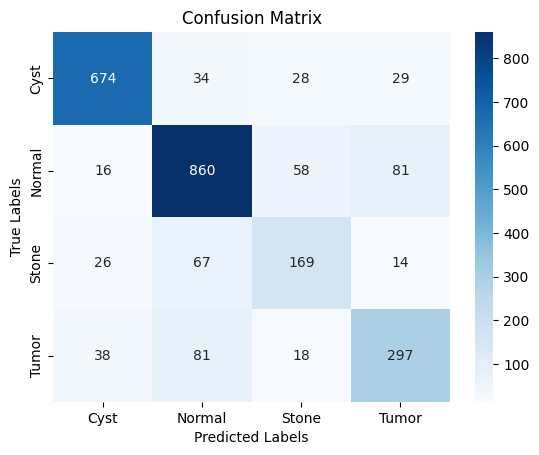

In [13]:
# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_directories.keys(), yticklabels=class_directories.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

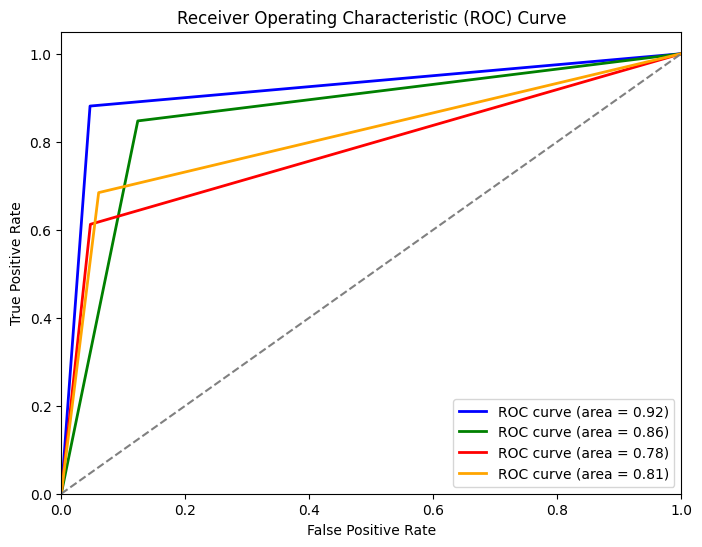

In [16]:
# Binarize the labels
y_test_bin = label_binarize(y_test, classes=['Cyst', 'Normal', 'Stone', 'Tumor'])

# Predict probabilities for each class
y_score = dt_classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode labels
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_encoded, y_pred_encoded))
print("RMSE:", rmse)


RMSE: 0.819932409791506
